In [2]:
#%matplotlib notebook
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

import pandas as pd
from pyjet import cluster
from pyjet.testdata import get_event
from pyjet import DTYPE_EP
from pyjet import DTYPE_PTEPM
from pyjet import PseudoJet, JetDefinition, ClusterSequence, ClusterSequenceArea

import math


#verbose = True
verbose = False


/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Original version of this code from Miguel Arratia, June 2021

## Get data, transform ROOT tree into array

In [3]:
#events = ur.open('root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/FULL/JETS/crossDivNrgCrab/DIS_NC_Q2gt10_crossDivNrgCrab_25mRad_18x275_v1.0097.root:events')
#events = ur.open('rec_highq2.root:events')
#gen_events = ur.open('sim_highq2.root:events')

#events = ur.open('rec_gen-q2min-100-1k.root:events')
#gen_events = ur.open('sim_gen-q2min-100-1k.root:events')

events = ur.open('rec_gen-100evts.root:events')
gen_events = ur.open('sim_gen-100evts.root:events')

In [4]:
def get_vector(varname='HcalHadronEndcapClusters',energy='energy'):
    E = events["%s.%s"%(varname,energy)].array(library='np')
    x = events["%s.position.x"%varname].array(library='np')
    y = events["%s.position.y"%varname].array(library='np')
    z = events["%s.position.z"%varname].array(library='np')
    theta = events["%s.polar.theta"%varname].array(library='np')
    phi = events["%s.polar.phi"%varname].array(library='np')

    return E,x, y, z, theta, phi

In [5]:
def get_truth():
    pdgID = gen_events['mcparticles.pdgID'].array(library='np')
    status = gen_events['mcparticles.status'].array(library='np')
    genStatus = gen_events['mcparticles.genStatus'].array(library='np')
    pex = gen_events['mcparticles.psx'].array(library='np')
    pey = gen_events['mcparticles.psy'].array(library='np')
    pez = gen_events['mcparticles.psz'].array(library='np')

    return pdgID,status, genStatus,pex,pey,pez

In [6]:
E = {}
x = {}
y = {}
z  = {}
theta={}
phi = {}


## Get clusters

In [7]:
for i in ['HcalHadronEndcapClusters','HcalBarrelClusters','EcalEndcapPClusters','EcalEndcapNClusters','EcalBarrelClusters']:
    E[i], x[i], y[i],z[i], theta[i], phi[i]= get_vector("%s"%i,energy='energy')

#### Owen: print out some stuff to understand the data structure

In [8]:
print(E.keys())

dict_keys(['HcalHadronEndcapClusters', 'HcalBarrelClusters', 'EcalEndcapPClusters', 'EcalEndcapNClusters', 'EcalBarrelClusters'])


In [9]:
print(len(E['HcalHadronEndcapClusters']))

100


In [10]:
for i in range(10):
    print('  Event %3d: %3d clusters' % (i, len(E['HcalHadronEndcapClusters'][i])))

  Event   0:  56 clusters
  Event   1:  18 clusters
  Event   2:  14 clusters
  Event   3:  14 clusters
  Event   4:  44 clusters
  Event   5:  33 clusters
  Event   6:  26 clusters
  Event   7:  44 clusters
  Event   8:  26 clusters
  Event   9:  25 clusters


In [11]:
for ei in range(3):
    for ci in range(len(E['HcalHadronEndcapClusters'][ei])):
        print("  Event %3d, cluster %3d :  E = %7.1f, xyz = (%8.1f, %8.1f, %8.1f)  theta,phi = (%7.3f, %7.3f)" % 
              (ei, ci, 
               E['HcalHadronEndcapClusters'][ei][ci], 
               x['HcalHadronEndcapClusters'][ei][ci],
               y['HcalHadronEndcapClusters'][ei][ci], 
               z['HcalHadronEndcapClusters'][ei][ci],
               theta['HcalHadronEndcapClusters'][ei][ci],
               phi['HcalHadronEndcapClusters'][ei][ci],
                )
             )

  Event   0, cluster   0 :  E =     3.5, xyz = (   -46.7,   1333.3,   3021.5)  theta,phi = (  0.416,   1.606)
  Event   0, cluster   1 :  E =    23.7, xyz = (  1153.7,   1291.2,   3021.5)  theta,phi = (  0.520,   0.842)
  Event   0, cluster   2 :  E = 13063.8, xyz = (   -85.1,   -118.8,   3021.5)  theta,phi = (  0.048,  -2.193)
  Event   0, cluster   3 :  E =    35.8, xyz = (   274.0,   -858.3,   3021.5)  theta,phi = (  0.290,  -1.262)
  Event   0, cluster   4 :  E =     4.5, xyz = (  1588.5,   2185.6,   3021.5)  theta,phi = (  0.730,   0.942)
  Event   0, cluster   5 :  E =    18.3, xyz = (  2296.7,  -1616.6,   3021.5)  theta,phi = (  0.749,  -0.613)
  Event   0, cluster   6 :  E =    18.2, xyz = (  2514.0,  -1655.1,   3021.5)  theta,phi = (  0.783,  -0.582)
  Event   0, cluster   7 :  E =    13.2, xyz = (   782.9,   2487.4,   3021.5)  theta,phi = (  0.712,   1.266)
  Event   0, cluster   8 :  E =   111.7, xyz = (   712.3,   -533.8,   3021.5)  theta,phi = (  0.286,  -0.643)
  Event   

## Get Truth info

In [12]:
mc = {} 
mc['pdgID'], mc['status'], mc['genStatus'], mc['pex'],mc['pey'], mc['pez']= get_truth()

#### Owen : print out some things to understand data structure

In [13]:
print( mc.keys() )

dict_keys(['pdgID', 'status', 'genStatus', 'pex', 'pey', 'pez'])


In [14]:
print( len(mc['pdgID']))

100


In [15]:
for ei in range(10):
    print( 'Event %3d has %5d mc pdgID entries' % ( ei, len(mc['pdgID'][ei])))

Event   0 has    52 mc pdgID entries
Event   1 has    94 mc pdgID entries
Event   2 has    52 mc pdgID entries
Event   3 has   114 mc pdgID entries
Event   4 has   103 mc pdgID entries
Event   5 has   122 mc pdgID entries
Event   6 has   120 mc pdgID entries
Event   7 has   101 mc pdgID entries
Event   8 has    94 mc pdgID entries
Event   9 has    58 mc pdgID entries


In [30]:
from particle import Particle

for ei in range(5):
    max = 200
    if len(mc['pdgID']) < max : max = len(mc['pdgID'][ei])
    print('-----------------------------------------------------------------------------------------------')
    print('non-final-state particles')
    for pi in range(max):
        if mc['genStatus'][ei][pi] == 1 : continue
        pdg_name = '???'
        try:
            pdg_particle = Particle.from_pdgid(mc['pdgID'][ei][pi])
            pdg_name = pdg_particle.name
        except:
            pdg_name = '??'

        print( 'Event %3d, mc %3d : pdgID = %7d %15s st = %5d, gst = %5d, p = (%7.1f, %7.1f, %7.1f)' % 
              (ei, pi, 
               mc['pdgID'][ei][pi],
               pdg_name,
               mc['status'][ei][pi],
               mc['genStatus'][ei][pi],
               mc['pex'][ei][pi],
               mc['pey'][ei][pi],
               mc['pez'][ei][pi],
              )
             )
 
    print('final-state particles')
    for pi in range(max):
        if mc['genStatus'][ei][pi] != 1 : continue
        pdg_name = '???'
        try:
            pdg_particle = Particle.from_pdgid(mc['pdgID'][ei][pi])
            pdg_name = pdg_particle.name
        except:
            pdg_name = '??'

        print( 'Event %3d, mc %3d : pdgID = %7d %15s st = %5d, gst = %5d, p = (%7.1f, %7.1f, %7.1f)' % 
              (ei, pi, 
               mc['pdgID'][ei][pi],
               pdg_name,
               mc['status'][ei][pi],
               mc['genStatus'][ei][pi],
               mc['pex'][ei][pi],
               mc['pey'][ei][pi],
               mc['pez'][ei][pi],
              )
             )
        

-----------------------------------------------------------------------------------------------
non-final-state particles
Event   0, mc   0 : pdgID =    2212               p st =    16, gst =     4, p = (   -0.0,    -0.0,   275.0)
Event   0, mc   1 : pdgID =       2               u st =   512, gst =    61, p = (   -2.7,     1.8,    31.0)
Event   0, mc   2 : pdgID =    2101         (ud)(0) st =   512, gst =    63, p = (    2.7,    -2.3,   243.8)
Event   0, mc   3 : pdgID =      11              e- st =    16, gst =     4, p = (    0.0,     0.0,   -18.0)
Event   0, mc   4 : pdgID =      11              e- st =   512, gst =    42, p = (   -0.0,     0.0,   -18.0)
Event   0, mc   5 : pdgID =       2               u st =   512, gst =    41, p = (    0.0,     0.0,    36.3)
Event   0, mc   6 : pdgID =      21               g st =   512, gst =    43, p = (   -0.7,    -1.4,     2.8)
Event   0, mc   7 : pdgID =      21               g st =   512, gst =    52, p = (   -0.6,    -1.2,     2.3)
Event 

Event   1, mc  66 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  67 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  68 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  69 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  70 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  71 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  72 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  73 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  74 : pdgID =     -22              ?? st = 76800, gst =     0, p = (   -0.0,    -0.0,     0.0)
Event   1, mc  75 :

Event   3, mc  37 : pdgID =    -213       rho(770)- st =  8196, gst =     2, p = (   -0.0,     0.0,     0.3)
Event   3, mc  39 : pdgID =    -313       K*(892)~0 st =  8196, gst =     2, p = (   -0.2,     0.4,     1.2)
Event   3, mc  40 : pdgID =     113       rho(770)0 st =  8196, gst =     2, p = (   -0.3,    -0.0,     2.0)
Event   3, mc  41 : pdgID =     111             pi0 st =  8196, gst =     2, p = (   -0.2,    -0.1,     1.1)
Event   3, mc  42 : pdgID =    1114    Delta(1232)- st =  8196, gst =     2, p = (   -0.7,    -0.3,    10.0)
Event   3, mc  43 : pdgID =     111             pi0 st =  8196, gst =     2, p = (   -0.0,    -0.3,     8.1)
Event   3, mc  44 : pdgID =   -1114   Delta(1232)~+ st =  8196, gst =     2, p = (   -1.1,    -0.3,    14.6)
Event   3, mc  47 : pdgID =     111             pi0 st =  8196, gst =     2, p = (   -0.1,     0.1,    33.5)
Event   3, mc  49 : pdgID =     111             pi0 st =  8196, gst =     2, p = (   -0.1,     0.1,     8.4)
Event   3, mc  50 :

Event   4, mc  27 : pdgID =    -213       rho(770)- st =  8196, gst =     2, p = (   -0.5,     0.4,     1.1)
Event   4, mc  28 : pdgID =     213       rho(770)+ st =  8196, gst =     2, p = (    0.3,     0.9,     3.5)
Event   4, mc  29 : pdgID =     223      omega(782) st =  8196, gst =     2, p = (    0.4,     0.1,     5.3)
Event   4, mc  31 : pdgID =     113       rho(770)0 st =  8196, gst =     2, p = (   -0.2,     0.4,    40.9)
Event   4, mc  33 : pdgID =      11              e- st =   512, gst =    23, p = (   -6.8,    -8.8,   -13.6)
Event   4, mc  37 : pdgID =     111             pi0 st =  8196, gst =     2, p = (    0.2,     0.5,     1.7)
Event   4, mc  43 : pdgID =     111             pi0 st =  8196, gst =     2, p = (   -0.2,     0.6,     0.6)
Event   4, mc  45 : pdgID =     111             pi0 st =  8196, gst =     2, p = (    0.3,     0.0,     0.7)
Event   4, mc  48 : pdgID =     111             pi0 st =  8196, gst =     2, p = (   -0.1,     0.0,     2.7)
Event   4, mc  60 :

## Loop over events, fill clusters into constituent arrays; run jet clustering 

In [16]:
jet_E = np.array([])
jet_eta = np.array([])

for ievt in range(10):
    constituents = np.array([], dtype=DTYPE_PTEPM)#DTYPE_EP)

    for i in range(len(mc['pdgID'][ievt])):
        if(mc['genStatus'][ievt][i]!=1): continue
        #print('MC particle ID ', mc['pdgID'][ievt][i], ' status = ', 
        #      mc['status'][ievt][i], 'genStatus ', mc['genStatus'][ievt][i],
        #      ' px = %2.2f, py=%2.2f, pz=%2.2f'%(mc['pex'][ievt][i],mc['pey'][ievt][i],mc['pez'][ievt][i]))
        print('MC particle ID %7d, status = %7d, genStatus = %7d, p = (%7.2f, %7.2f, %7.2f)' %
              (mc['pdgID'][ievt][i],
               mc['status'][ievt][i],
               mc['genStatus'][ievt][i],
               mc['pex'][ievt][i],mc['pey'][ievt][i],mc['pez'][ievt][i]
              )
             )
    
    
    print('\nEcal barrel clusters ###########################')
    for i in range(len(E['EcalEndcapPClusters'][ievt])):
        part_energy = E['EcalEndcapPClusters'][ievt][i]/1000.0
        if(part_energy<0.100):
            continue
        part_phi = phi['EcalEndcapPClusters'][ievt][i]
        part_theta = theta['EcalEndcapPClusters'][ievt][i]
        part_eta = np.log(np.tan(part_theta/2.0))
        part_pt  = part_energy*np.sin(part_theta)
        
        #print('Energy=%2.2f GeV, phi =%2.2f rad,  eta=%2.2f, pT = %2.2f GeV'%(part_energy,part_phi, part_eta,part_pt))
        
        print('Energy=%6.2f GeV, phi = %7.3f rad,  eta = %6.3f, pT = %6.2f GeV' % (part_energy,part_phi, part_eta,part_pt)
             )
        
        cluster = np.array([(part_pt, part_eta, part_phi, 0.0)], dtype=DTYPE_PTEPM)
        constituents = np.append(constituents, cluster)
        
        
    print('\nHcal barrel clusters ########')

    for i in range(len(E['HcalBarrelClusters'][ievt])):
        part_energy = E['HcalBarrelClusters'][ievt][i]/1000.0
        if(part_energy<0.25):
            continue
        part_phi = phi['HcalBarrelClusters'][ievt][i]
        part_theta = theta['HcalBarrelClusters'][ievt][i]
        part_eta = -np.log(np.tan(part_theta/2.0))
        part_pt  = part_energy*np.sin(part_theta)
        
        #print('Energy=%2.2f GeV, phi =%2.2f rad, theta= %2.2f rad, eta=%2.2f, pT = %2.2f GeV'%(part_energy,part_phi,part_theta, part_eta,part_pt))
        
        print('Energy=%6.2f GeV, phi = %7.3f rad,  eta = %6.3f, pT = %6.2f GeV' % (part_energy,part_phi, part_eta,part_pt)
             )
        
        cluster = np.array([(part_pt, part_eta, part_phi, 0.0)], dtype=DTYPE_PTEPM)
        constituents = np.append(constituents, cluster)

    #Loop over ECalENDCAP clusters
    #print('ECal Endcap clusters')
    #for i in range(len(E['EcalEndcapClusters'][ievt])):
    #    part_energy = E['EcalEndcapClusters'][ievt][i]/1000.0
    #    if(part_energy<0.100):
    #        continue
    #    part_phi = phi['EcalEndcapClusters'][ievt][i]
    #    part_theta = theta['EcalEndcapClusters'][ievt][i]
    #    part_eta = -np.log(np.tan(part_theta/2.0))
    #    part_pt  = part_energy*np.sin(part_theta)
    #    print('Energy=%2.2f GeV, phi =%2.2f rad, theta= %2.2f rad, eta=%2.2f, pT = %2.2f GeV'%(part_energy,part_phi,part_theta, part_eta,part_pt))
    #    cluster = np.array([(part_pt, part_eta, part_phi, 0.0)], dtype=DTYPE_PTEPM)
    #    constituents = np.append(constituents, cluster)
    print('#################################\n\n')
        


print(constituents)

#print(jet_E)
#print(jet_eta)

MC particle ID    2212, status =   20482, genStatus =       1, p = (  -0.42,   -4.05,    3.77)
MC particle ID   -2112, status =   20482, genStatus =       1, p = (  -0.22,   -5.37,    4.43)
MC particle ID   -2112, status =   20482, genStatus =       1, p = (   0.47,   -2.18,    3.37)
MC particle ID    -211, status =   20482, genStatus =       1, p = (  -0.81,   -0.55,    2.28)
MC particle ID    -211, status =   20482, genStatus =       1, p = (   0.13,   -0.46,   17.99)
MC particle ID    2212, status =   20482, genStatus =       1, p = (   2.33,   -1.54,  188.14)
MC particle ID      11, status =   24578, genStatus =       1, p = (  -0.90,   21.95,   -4.45)
MC particle ID    2212, status =   20482, genStatus =       1, p = (  -1.02,   -4.77,    4.34)
MC particle ID    -211, status =   24578, genStatus =       1, p = (  -0.11,   -1.82,    1.85)
MC particle ID     211, status =   20482, genStatus =       1, p = (   0.04,   -0.13,    1.26)
MC particle ID    -211, status =   20482, genStatu

In [22]:

#--- This is the second thing called in the analysis loop

def isolation( cone_theta, cone_phi, cluster_container, E_threshold=0.1):
    
    if verbose : print('\n    --- in isolation:')
    
    nclusters= len(cluster_container['E'])
    #if(cone_theta<0.05):
    #    return -999
    
    cone_eta = -np.log(np.tan(cone_theta/2.0))
    cone_iso = 0.0
    
    for i in range(nclusters):
        
        clus_E = cluster_container['E'][i]/1000.0
        
        if(clus_E<E_threshold):
            continue
        
        # if verbose : print('      Cluster E =%2.2f'%(clus_E))
        
        clus_E = cluster_container['E'][i]/1000.0
        clus_phi = cluster_container['phi'][i]
        clus_theta = cluster_container['theta'][i]
        clus_eta = -np.log(np.tan(clus_theta/2.0))
        clus_pt  = clus_E*np.sin(clus_theta)
        
        # if verbose : print('      Cluster E =%2.5f, cluster phi =%2.2f, cluster theta=%2.5f, cluster eta=%2.2f'%(clus_E,clus_phi,clus_theta,clus_eta))
        
        dphi = clus_phi - cone_phi
        dphi = (dphi + np.pi) % (2 * np.pi) - np.pi
        
        # if verbose : print('       Delta- phi = %2.2f'%(dphi))
        
        dr = np.sqrt((dphi)**2 + (clus_eta-cone_eta)**2)
        
        # if verbose : print('      dr=%2.2f (cone eta %2.2f, cone azimuth=%2.2f), so dphi =%2.2f'%(dr,cone_eta,cone_phi,dphi))
        
        if(dr<1.0): 
            cone_iso += clus_E
    
    if verbose : print('      Cone phi %2.2f, cone eta %2.2f, cone theta %2.2f, cone E= %2.2f GeV\n'%(cone_phi, cone_eta, cone_theta, cone_iso))
    
    
    
    return cone_iso





#-- This is the third thing called in the analysis loop.

def find_truth_electron(mc_container):
    ptmax = 0.0
    index_e = -999
    for i in range(len(mc_container['pdgID'])):
        if (mc_container['pdgID'][i]!=11): continue
        px = mc_container['pex'][i]
        py = mc_container['pey'][i]
        pt = np.sqrt(px*px+py*py)
        if(pt>ptmax):
            ptmax = pt
            index_e=i
    #print('The scattered electron found has the following: %2.2f'%ptmax)
    if verbose : 
        if index_e > -1 :
            px = mc_container['pex'][index_e]
            py = mc_container['pey'][index_e]
            pz = mc_container['pez'][index_e]
            pt = np.sqrt(px*px+py*py)
            te_phi = math.atan2(py,px)            
            te_theta = math.atan2(pt,pz)
            print('\n       find_truth_electron : index = %d truth pT = %7.1f, pz = %7.1f theta(deg), phi = (%7.1f, %7.3f)\n' % 
              ( index_e, ptmax, pz, te_theta*180./3.14159265, te_phi ) )
        
    return index_e






#-- This is the first thing called in the analysis loop.

def find_electron( cluster_container, hcal_container, E_threshold=3.0):

    #Returns cluster with the highest pT in the event
    #print(cluster_container.keys())

    if verbose : print(' --- in find_electron:')
    
    ptmax = 0.0
    electron_iso = 999
    index_max = -999
    nclusters= len(cluster_container['E'])

    for i in range(nclusters):
        
        #if verbose : print('    find_electron: checking cluster %d' % i )
        
        clus_E = cluster_container['E'][i]/1000.0
        if(clus_E<E_threshold):
            continue
        if(cluster_container['theta'][i]*180.0/np.pi<2):
            continue
        clus_theta = cluster_container['theta'][i]
        clus_phi = cluster_container['phi'][i]

        clus_eta = -np.log(np.tan(clus_theta/2.0))
        clus_pt  = clus_E*np.sin(clus_theta)
        
        if verbose : print('      Ecal isolation for cluster %d' % i )
        clus_ecal_iso = isolation(clus_theta,clus_phi, cluster_container)
        
        if verbose : print('      Hcal isolation for cluster %d' % i )
        clus_hcal_iso = isolation(clus_theta,clus_phi, hcal_container)
        clus_iso = clus_ecal_iso + clus_hcal_iso - clus_E
        
        #remove non-isolated clusters
        if(clus_iso>clus_E*0.1): 
            if verbose : print('          *** failed isolation req.  iso > 0.1 * E  : %7.1f > 0.1 * %7.1f\n' % (clus_iso, clus_E) )
            continue
        
        if verbose : print('         passed isolation req.')
        
        
        if(clus_pt>ptmax):
            ptmax = clus_pt
            index_max = i
            electron_iso= clus_iso 
        
        
    if verbose :
            
        if(index_max>0):
        
            print('\n\n\n find_electron : This is the electron candidate:  index_max = %d' % index_max )
            print('      ptmax %2.2f GeV'%ptmax, 'energy %2.2f GeV'%(cluster_container['E'][index_max]/1000.0))
            print('      polar angle %2.2f, azimthal angle =%2.2f, degrees '%(cluster_container['theta'][index_max]*180.0/np.pi,cluster_container['phi'][index_max]))
            print('      ISOLATION (R=1.0) isolation = %2.2f GeV'%(electron_iso))
            print('      clus ECAL iso =%2.2f, HCAL iso =%2.2f'%(clus_ecal_iso,clus_hcal_iso))
    
        print('index_max = %d ' % index_max)
        print('ending finding electron routine\n\n')
            
    return index_max






#-- Owen: presumably Empz stands for "E minus pz".  This is Sigma.
    
def get_Empz(cluster_container,skip=None):
    nclusters= len(cluster_container['E'])
    Empz = 0.0
    #print('nclusters ', nclusters)
    for i in range(nclusters):
        if( skip is not None):
            if(skip==i):
                #print('Skipping electron %i'%(skip))
                continue
        #print(cluster_container['E'][i])
        Empz += cluster_container['E'][i]*(1-np.cos(cluster_container['theta'][i]))
    #print(Empz)
    return Empz/1000.0







def get_total_pxpy(cluster_container,E_threshold=0.1,skip=None):
    nclusters= len(cluster_container['E'])
    sum_px = 0.0
    sum_py = 0.0
    sum_pt = 0.0
    for i in range(nclusters):
        
        if( skip is not None):
            if(skip==i):
                #print('Skipping electron %i'%(skip))
                continue
        
        clus_E = cluster_container['E'][i]/1000.0
        if(clus_E<E_threshold):
            continue
        clus_phi =   cluster_container['phi'][i]
        clus_theta = cluster_container['theta'][i]
        clus_eta = -np.log(np.tan(clus_theta/2.0))
        clus_pt  = clus_E*np.sin(clus_theta)
        clus_px  = clus_pt*np.cos(clus_phi)
        clus_py  = clus_pt*np.sin(clus_phi)
        sum_px += clus_px
        sum_py += clus_py
    sum_pt = np.sqrt(sum_px*sum_px + sum_py*sum_py)
    #print('sum px', sum_px)
    #print('sum py', sum_py)
    #print('sum pt ', sum_pt)
    return sum_px, sum_py



In [23]:
def get_kinematics_electron(e_index, cluster_container,beam_energy = 18.0):
    #print('e index ', e_index)
    electron_E = cluster_container['E'][e_index]/1000.0
    electron_theta = cluster_container['theta'][e_index]
    electron_pt  = electron_E*np.sin(electron_theta)

    #print('Electron E %2.2f, angle =%2.2f'%(electron_E,electron_theta))
    y  = 1 - (electron_E/(2.0*beam_energy))*(1-np.cos(electron_theta))
    Q2 = electron_pt**2/(1-y)
    #print('Q2=%2.2f , y =%2.2f'%(Q2, y))
    return Q2, y




def get_kinematics_electron_truth(px,py,pz,beam_energy=18.0):
    electron_E = np.sqrt(px*px+py*py+pz*pz)
    electron_pt = np.sqrt(px*px+py*py)
    electron_theta = np.arccos(pz/electron_E)

    y  = 1 - (electron_E/(2.0*beam_energy))*(1-np.cos(electron_theta))
    Q2 = electron_pt**2/(1-y)
    return Q2, y, electron_E, electron_theta

In [24]:

evt_Q2 = np.array([])
evt_y = np.array([])
evt_Total = np.array([])
evt_Empz = np.array([])
evt_yh  = np.array([])
evt_Q2h = np.array([])
evt_ysigma  = np.array([])
evt_Q2sigma = np.array([])
gen_evt_Q2 = np.array([])
gen_evt_y = np.array([])

evt_e_eta = np.array([])
evt_e_E = np.array([])
evt_e_phi = np.array([])


jet_dphi = np.array([])
jet_ptratio = np.array([])
jet_eta = np.array([])
jet_E = np.array([])
jet_phi = np.array([])



for ievt in range(len(E['HcalBarrelClusters'])):
#for ievt in range(100):
#for ievt in range(10):
    
    if verbose : print('\n\n\n++++++++++++ ievent' , ievt)
    
    constituents = np.array([], dtype=DTYPE_PTEPM)#DTYPE_EP)
    hcal_clusters = {}
    ecal_clusters = {}
    hcal_clusters['E']     = np.concatenate((E['HcalBarrelClusters'][ievt], E['HcalHadronEndcapClusters'][ievt]), axis=0)
    hcal_clusters['phi']   = np.concatenate((phi['HcalBarrelClusters'][ievt], phi['HcalHadronEndcapClusters'][ievt]), axis=0)
    hcal_clusters['theta'] = np.concatenate((theta['HcalBarrelClusters'][ievt], theta['HcalHadronEndcapClusters'][ievt]), axis=0)
    ecal_clusters['E']     = np.concatenate((E['EcalEndcapNClusters'][ievt],E['EcalBarrelClusters'][ievt], E['EcalEndcapPClusters'][ievt]), axis=0)
    ecal_clusters['phi']   = np.concatenate((phi['EcalEndcapNClusters'][ievt],phi['EcalBarrelClusters'][ievt], phi['EcalEndcapPClusters'][ievt]), axis=0)
    ecal_clusters['theta'] = np.concatenate((theta['EcalEndcapNClusters'][ievt],theta['EcalBarrelClusters'][ievt], theta['EcalEndcapPClusters'][ievt]), axis=0)
    
    
    e_index = find_electron( ecal_clusters, hcal_clusters )

    if verbose : print('\n   e_index = %d\n' % e_index )
    
    if(e_index<0): 
        if verbose : print('         Electron candidate with minimum 5 GeV energy was not found')
        continue
        
    electron_E = ecal_clusters['E'][e_index]/1000.0
    electron_theta = ecal_clusters['theta'][e_index]
    electron_phi  = ecal_clusters['phi'][e_index]
    
    #print('electron theta', electron_theta)
    
    evt_mc = {}
    evt_mc['pdgID'] = mc['pdgID'][ievt]
    evt_mc['genStatus'] = mc['genStatus'][ievt]
    evt_mc['pex'] = mc['pex'][ievt]
    evt_mc['pey'] = mc['pey'][ievt]
    evt_mc['pez'] = mc['pez'][ievt]
    
    evt_mc = pd.DataFrame.from_dict(evt_mc)
    evt_mc.eval('E= sqrt(pex*pex + pey*pey + pez*pez) ',inplace=True)
    evt_mc.eval('pt = sqrt(pex*pex + pey*pey)',inplace=True)
    evt_mc.head()
    
    #Find true electron
    e_truth_index = find_truth_electron(evt_mc)
    
    
    
    
    
    
    
    
    #print('Electron truth index ', e_truth_index)
    genQ2, geny, gen_leptonE, gen_leptonTheta = get_kinematics_electron_truth(evt_mc['pex'][e_truth_index],evt_mc['pey'][e_truth_index],evt_mc['pez'][e_truth_index])
    
    

    
    gen_evt_Q2 = np.append(gen_evt_Q2,genQ2)
    gen_evt_y = np.append(gen_evt_y,geny)


    if verbose : print('TRUE VALUES OF E = %7.2f , theta = %7.3f'%(gen_leptonE,gen_leptonTheta))

    if verbose :  
        print( '  Computing ECAL iso around electron')
        ecal_iso = isolation(electron_theta, electron_phi, ecal_clusters)
        print( '  Computing HCAL iso around electron')
        hcal_iso = isolation(electron_theta, electron_phi, hcal_clusters)
        iso = ecal_iso + hcal_iso - electron_E
        print('Electron candidate is %2.2f =, angle=%2.2f, iso =%2.2f'%(electron_E,electron_theta*180.0/np.pi,iso))
    
    
    
    
    Q2, y= get_kinematics_electron(e_index,ecal_clusters)
    evt_Q2 = np.append(evt_Q2, Q2)
    evt_y = np.append(evt_y, y)

    if verbose : print('TRUE  VALUES OF Q2 = %7.1f , y = %6.3f'%(genQ2,geny))
    if verbose : print('RECO  values of Q2 = %7.1f , y = %6.3f' % (Q2, y))
        
        
        
        

    Empz = get_Empz(hcal_clusters) + get_Empz(ecal_clusters,skip=e_index)
    
    #-- owen:  Note that the evaluation above skips the electron (as it should be) but the one below does not.  Why?
    #          Miguel said that if you include the electron, the distribution should peak ner 2 Ebeam.
    #          The Empz variable above is used in the sigma calculations below and it doesn't include the
    #          electron, which is correct.
    
    evt_Empz = np.append(evt_Empz, get_Empz(hcal_clusters) + get_Empz(ecal_clusters))

    if verbose : print('Sigma (aka Empz) from clusters: %7.1f' % Empz)
    
  
    ecal_px, ecal_py = get_total_pxpy(ecal_clusters,skip=e_index)
    hcal_px , hcal_py = get_total_pxpy(hcal_clusters)
    total_px = ecal_px + hcal_px
    total_py = hcal_py + hcal_py
    #print('TOTAL ', total_px, total_py)
    TOT = np.sqrt(total_px*total_px + total_py*total_py)
    #print('TOT = %2.2f'%TOT)
    evt_Total = np.append(evt_Total, TOT)

    if verbose : print('Total from hadrons:  px = %7.2f,  py = %7.2f' % (total_px, total_py))
    
    
    ##Hadronic reconstruction (Jacquet Blondel)
    y_h = Empz/(2.0*18.0)
    Q2_h = TOT*TOT/(1.0-y_h)
    evt_yh = np.append(evt_yh, y_h)
    evt_Q2h = np.append(evt_Q2h, Q2_h)
    
    if verbose : print('JBhad values of Q2 = %7.1f , y = %6.3f' % (Q2_h, y_h))
        
    #print('electron theta %2.2f' %(electron_theta), ' electron energy =%2.2f'%(electron_E))
    ## Sigma method
    #print('Empz = %2.2f '%(Empz))
    #print('electron_E*(1-np.cos(electron_theta)) =%2.2f'%(electron_E*(1-np.cos(electron_theta))))
    y_sigma = Empz/(Empz + electron_E*(1-np.cos(electron_theta)))
    Q2_sigma= (electron_E*electron_E)*(np.sin(electron_theta)*np.sin(electron_theta))/(1-y_sigma)
    evt_ysigma = np.append(evt_ysigma, y_sigma)
    evt_Q2sigma = np.append(evt_Q2sigma, Q2_sigma)
    
    if verbose : print('Sigma values of Q2 = %7.1f , y = %6.3f' % (Q2_sigma, y_sigma))
    
    #print('y =%2.2f, y_h = %2.2f, Q2=%2.2f , Q2_h=%2.2f'%(y,y_h,Q2,Q2_h))
    #print('y_sigma = %2.2f, Q2_sigma=%2.2f'%(y_sigma,Q2_sigma))

    constituents = np.array([], dtype=DTYPE_PTEPM)#DTYPE_EP)
    #looping over HCAl clusters
    for i in range(len(hcal_clusters['E'])):
        part_energy = hcal_clusters['E'][i]/1000.0
        if(part_energy<0.5):
            continue
        part_phi = hcal_clusters['phi'][i]
        part_theta = hcal_clusters['theta'][i]
        part_eta = -np.log(np.tan(part_theta/2.0))
        part_pt  = part_energy*np.sin(part_theta)
        #print('Energy=%2.2f GeV, phi =%2.2f rad, theta= %2.2f rad, eta=%2.2f, pT = %2.2f GeV'%(part_energy,part_phi,part_theta, part_eta,part_pt))
        cluster = np.array([(part_pt, part_eta, part_phi, 0.0)], dtype=DTYPE_PTEPM)
        constituents = np.append(constituents, cluster)
    #looping over ECal clusters
    for i in range(len(ecal_clusters['E'])):
        part_energy = ecal_clusters['E'][i]/1000.0
        if(part_energy<0.100):
            continue
        if (i==e_index):
            continue
        part_phi = ecal_clusters['phi'][i]
        part_theta = ecal_clusters['theta'][i]
        part_eta = -np.log(np.tan(part_theta/2.0))
        part_pt  = part_energy*np.sin(part_theta)
        #print('Energy=%2.2f GeV, phi =%2.2f rad, theta= %2.2f rad, eta=%2.2f, pT = %2.2f GeV'%(part_energy,part_phi,part_theta, part_eta,part_pt))
        cluster = np.array([(part_pt, part_eta, part_phi, 0.0)], dtype=DTYPE_PTEPM)
        constituents = np.append(constituents, cluster)
        
        
    ### Jet reconstruction    
    jet_def = JetDefinition(algo = 'genkt', R = 1.0,p=-1.0)
    cs = ClusterSequence(constituents, jet_def) 
    jets = cs.inclusive_jets()
    #print(jets.pt)
    evt_e_eta = np.append(evt_e_eta, -np.log(np.tan(ecal_clusters['theta'][e_index]/2.0)))
    evt_e_E = np.append(evt_e_E,0.001*ecal_clusters['E'][e_index])
    evt_e_phi = np.append(evt_e_phi, ecal_clusters['phi'][e_index])
    #print('JETS')
    for jet in jets:
        if(jet.pt<5): continue
        #print(jet.pt*np.cosh(jet.eta))
        jet_E = np.append(jet.pt*np.cosh(jet.eta),jet_E)
        jet_eta = np.append(jet.eta,jet_eta)
        #print('jet pt =%2.2f, jet_phi= %2.2f, jet_eta=%2.2f'%(jet.pt,jet.phi,jet.eta))
        jet_phi = np.append(jet_phi, jet.phi)
        jet_dphi = np.append(jet_dphi,np.abs(ecal_clusters['phi'][e_index]-jet.phi) )
        jet_ptratio = np.append(jet_ptratio, jet.pt/(0.001*ecal_clusters['E'][e_index]*np.sin(ecal_clusters['theta'][e_index])))
        
   # print('#################################')

    
    #Loop over 

In [25]:
df = {}
df['Q2'] = evt_Q2
df['y'] = evt_y
df['ETotal'] = evt_Total
df['Empz'] = evt_Empz 
df['yh'] = evt_yh
df['Q2h'] = evt_Q2h
df['ysigma'] = evt_ysigma
df['Q2sigma'] = evt_Q2sigma
df['e_E'] = evt_e_E
df['e_eta'] = evt_e_eta
df['e_phi'] = evt_e_phi
df['gen_Q2'] = gen_evt_Q2
df['gen_y'] = gen_evt_y



df = pd.DataFrame.from_dict(df)
df.eval('yh_ratio = yh/gen_y',inplace=True)
df.eval('ysigma_ratio = ysigma/gen_y',inplace=True)
df.eval('y_ratio = y/gen_y',inplace=True)

In [26]:
df['gen_Q2'].min()

98.36839430997239

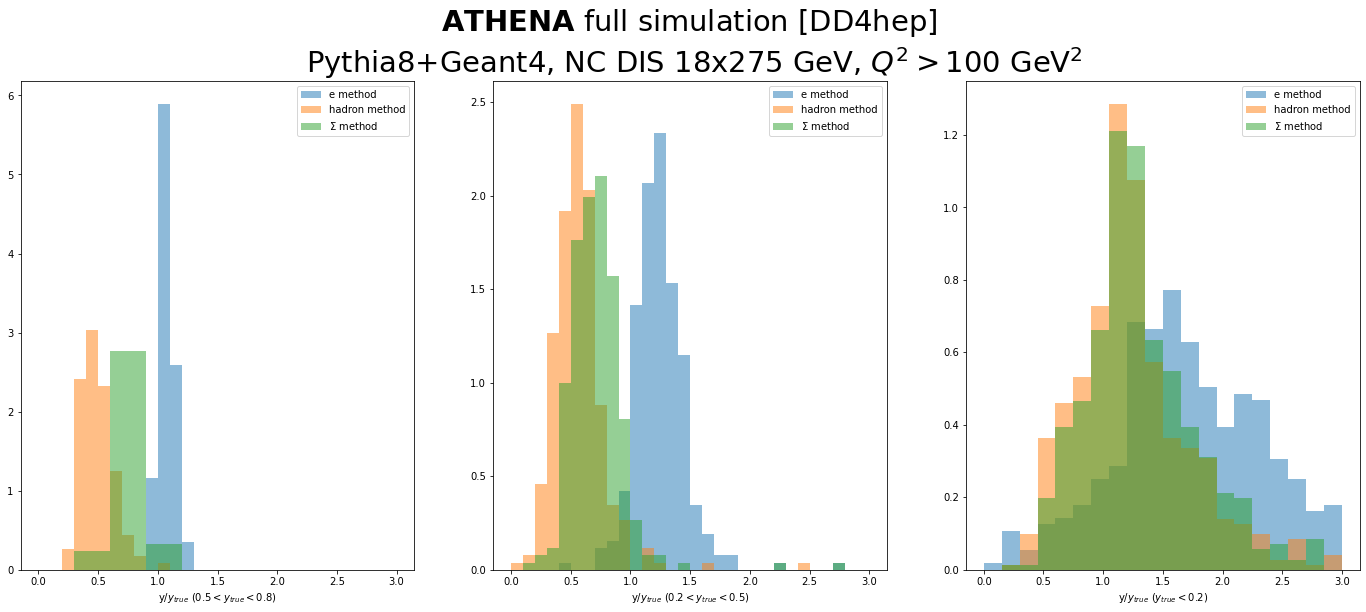

In [27]:
fig,ax = plt.subplots(1,3,figsize=(24,9))
ax = ax.flatten()
ax[0].hist(df.query('gen_y>0.5 and gen_y<0.8')['y_ratio'],density=True,bins=30,range=(0,3),alpha=0.5,label='e method')
ax[0].hist(df.query('gen_y>0.5 and gen_y<0.8')['yh_ratio'],density=True,bins=30,range=(0,3),alpha=0.5,label='hadron method')
ax[0].hist(df.query('gen_y>0.5 and gen_y<0.8')['ysigma_ratio'],density=True,bins=10,range=(0,3),alpha=0.5,label='$\Sigma$ method')
ax[0].legend()

ax[1].hist(df.query('gen_y<0.5 and gen_y>0.2')['y_ratio'],density=True,bins=30,range=(0,3),alpha=0.5,label='e method')
ax[1].hist(df.query('gen_y<0.5 and gen_y>0.2')['yh_ratio'],density=True,bins=30,range=(0,3),alpha=0.5,label='hadron method')
ax[1].hist(df.query('gen_y<0.5 and gen_y>0.2')['ysigma_ratio'],density=True,bins=30,range=(0,3),alpha=0.5,label='$\Sigma$ method')
ax[1].legend()


ax[2].hist(df.query('gen_y<0.2 ')['y_ratio'],density=True,bins=20,range=(0,3),alpha=0.5,label='e method')
ax[2].hist(df.query('gen_y<0.2 ')['yh_ratio'],density=True,bins=20,range=(0,3),alpha=0.5,label='hadron method')
ax[2].hist(df.query('gen_y<0.2 ')['ysigma_ratio'],density=True,bins=20,range=(0,3),alpha=0.5,label='$\Sigma$ method')
ax[2].legend()
ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)



ax[0].set_xlabel(r'y/$y_{true}$ ($0.5<y_{true}<0.8$)')

ax[1].set_xlabel(r'y/$y_{true}$ ($0.2<y_{true}<0.5$)')
ax[2].set_xlabel(r'y/$y_{true}$ ($y_{true}<0.2$)')

plt.show()


## Plotting 

In [28]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties

from numpy import inf

import os

rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

import matplotlib.pyplot as plt
import mplhep as hep
#hep.set_style(hep.style.CMS)
hep.set_style("CMS")

<ipython-input-28-4082e46a6be7>:37: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("CMS")


## Plot jet energy spectrum

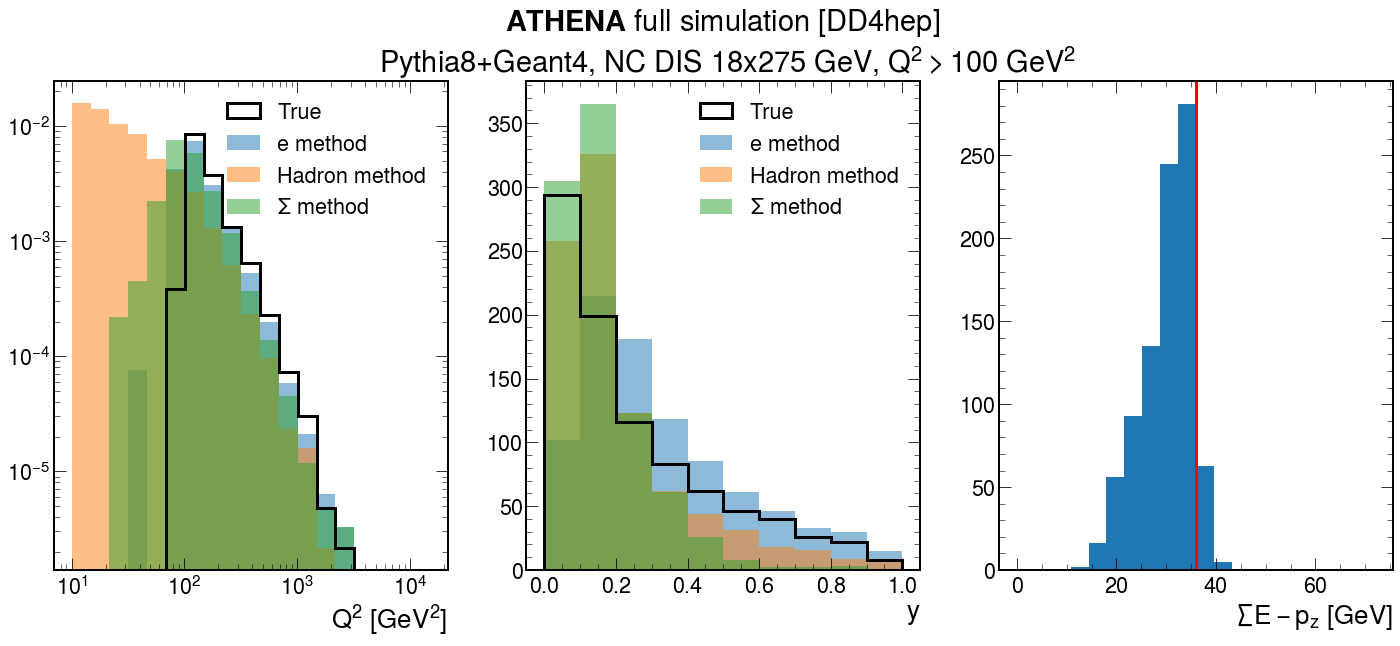

In [29]:
fig,ax = plt.subplots(1,3,figsize=(24,9))
ax = ax.flatten()
ax[0].hist(gen_evt_Q2,density=True,bins=np.geomspace(10,15000,20),histtype='step',color='black',lw=3,alpha=1,label='True')
ax[0].hist(evt_Q2,density=True,bins=np.geomspace(10,15000,20),alpha=0.5,label='e method')
ax[0].hist(evt_Q2h,density=True,bins=np.geomspace(10,15000,20),alpha=0.5,label='Hadron method' )
ax[0].hist(evt_Q2sigma,density=True,bins=np.geomspace(10,15000,20),alpha=0.5,label='$\Sigma$ method' )


ax[0].legend(loc='best')
ax[1].hist(gen_evt_y,bins=10,range=(0,1.0),alpha=1, lw=3,histtype='step',color='black',label='True')
ax[1].hist(evt_y,bins=10,range=(0,1.0),alpha=0.5,label='e method')
ax[1].hist(evt_ysigma,bins=10,range=(0,1.0),alpha=0.5,label='Hadron method')
ax[1].hist(evt_yh,bins=10,range=(0,1.0),alpha=0.5, label='$\Sigma$ method')

#ax[3].hist(evt_MET,bins=10)
ax[2].hist(evt_Empz,bins=20,range=(0,72))

#plt.text(0.80, 0.77,'18 x 275 GeV \n $Q^{2}>100~GeV^{2}$ \n anti $k_{T}$, $R=1.0$ \n $\eta^{jet}>1.0$ \n calorimetric reco',
#                 horizontalalignment='center',multialignment='left',
#                 verticalalignment='center',transform = ax.transAxes, fontsize=20)
ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
#ax[0].set_ylabel('Normalized entries')
ax[0].set_xlabel(r'$Q^{2}$ [GeV$^{2}$]')
ax[1].set_xlabel(r'$y$')
#ax[3].set_xlabel(r'Missing Transverse Energy [GeV]')
ax[2].set_xlabel(r'$\sum E - p_{z}$ [GeV]')
ax[2].axvline(2*18.0,color='red',lw=3,label='2 $E_{e}$')
ax[1].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')
#ax[1].set_yscale('log')

plt.show()

Text(1, 0, '$\\Delta\\phi_{electron-jet}$ [rad]')

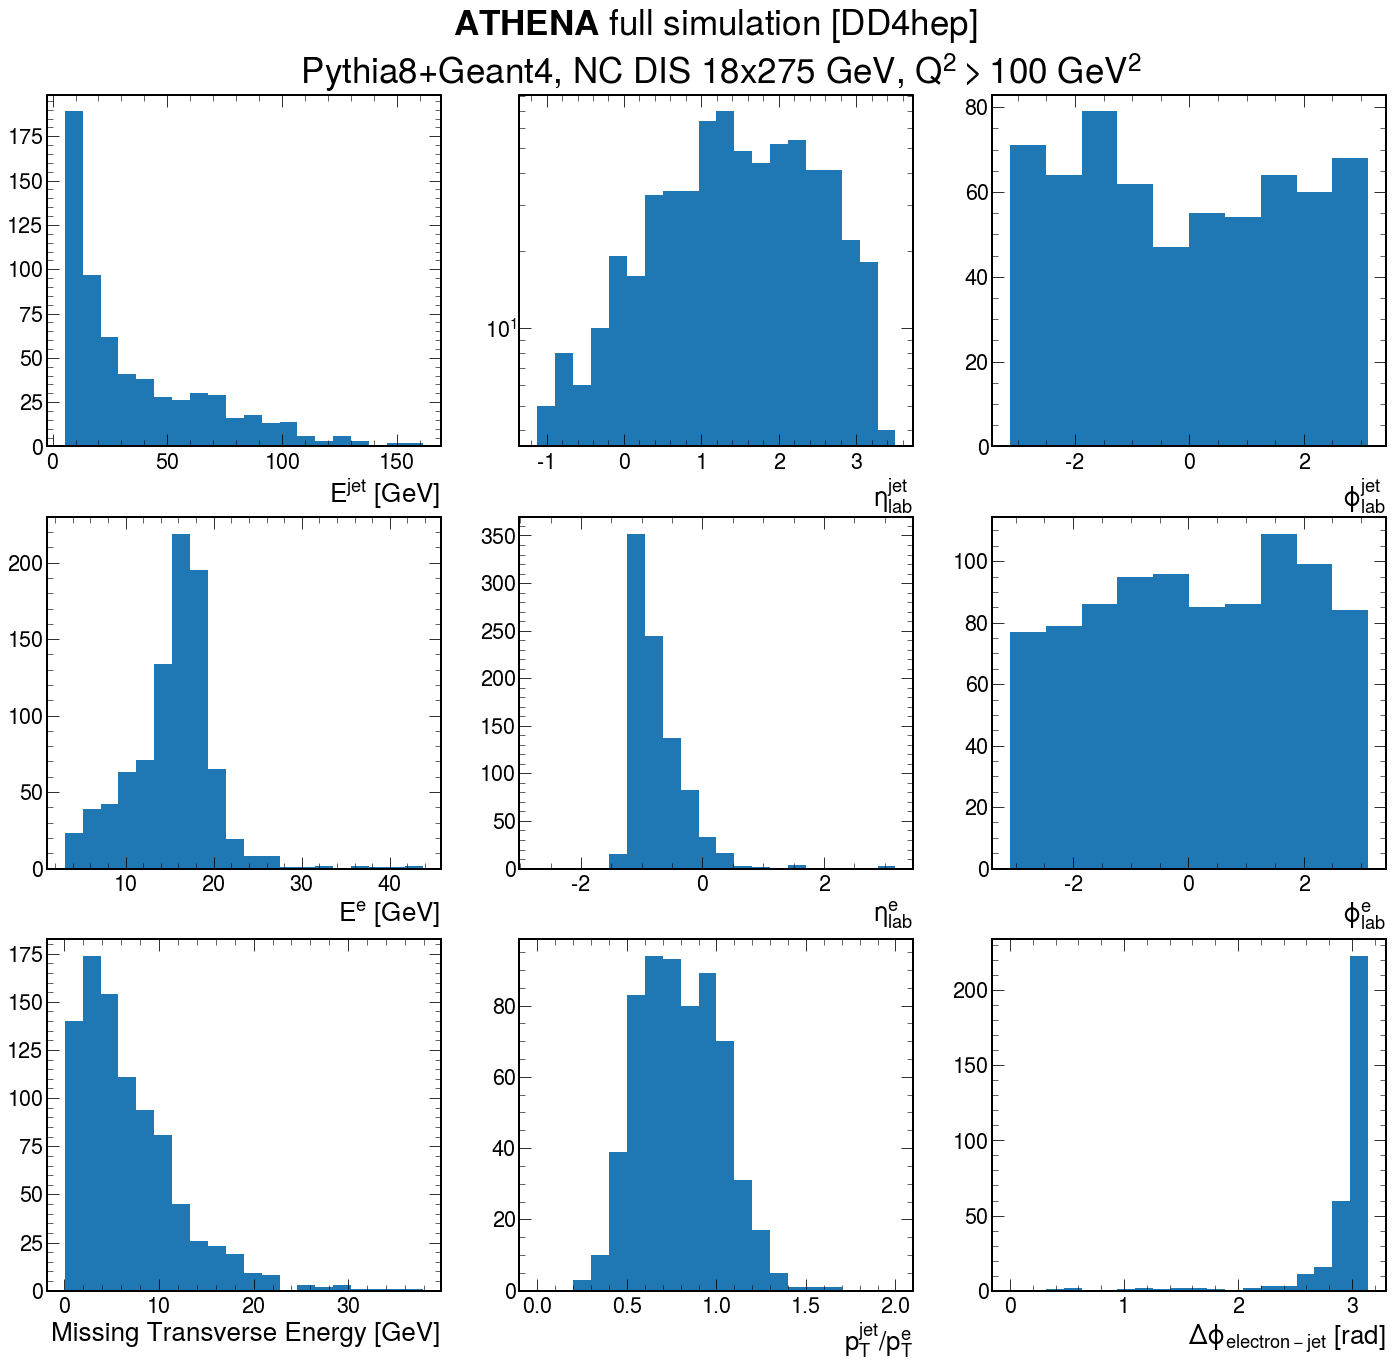

In [30]:
fig,ax = plt.subplots(3,3,figsize=(24,22))
ax = ax.flatten()

ax[0].hist(jet_E,bins=20)
ax[1].hist(jet_eta,bins=20)
ax[2].hist(jet_phi,bins=10)

ax[3].hist(evt_e_E,bins=20)
ax[4].hist(evt_e_eta,bins=20)
ax[5].hist(evt_e_phi,bins=10)

ax[6].hist(evt_Total,bins=20)
ax[7].hist(jet_ptratio,bins=20,range=(0,2))
ax[8].hist(jet_dphi,bins=20,range=(0,np.pi))

ax[1].set_yscale('log')
ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=35)


ax[0].set_xlabel('$E^{jet}$ [GeV]')
ax[1].set_xlabel('$\eta^{jet}_{lab}$')
ax[2].set_xlabel('$\phi^{jet}_{lab}$')

ax[3].set_xlabel('$E^{e} $ [GeV]')
ax[4].set_xlabel('$\eta^{e}_{lab}$')
ax[5].set_xlabel('$\phi^{e}_{lab}$')

ax[6].set_xlabel('Missing Transverse Energy [GeV]')
ax[7].set_xlabel('$p_{T}^{jet}/p_{T}^{e}$')
ax[8].set_xlabel('$\Delta\phi_{electron-jet}$ [rad]')




In [31]:
#gen_events=  ur.open('root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/FULL/JETS/crossDivNrgCrab/DIS_NC_Q2gt10_crossDivNrgCrab_25mRad_18x275_v1.0097.root:events')
#gen_ak_arrays = gen_events.arrays(filter_name='*mcparticle*')
#%time
#events.keys(filter_name='*Clusters*')
#ak_arrays = events.arrays(filter_name='*Clusters*')
#for batch in events.iterate(step_size="1 MB",filter_name='*Clusters*'):
#    print(type(batch))